In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

Constructs the encoding circuit for [[5,1,3]] 

In [3]:
def create_5qubit_encoder():
    """
    Creates the encoding circuit for the 5-qubit code.
    Maps |0_L> and |1_L> to their encoded states.
    """
    qc = QuantumCircuit(5)
    
    # The 5-qubit code encodes:
    # |0_L> = (|00000> + |10010> + |01001> + |10100> + 
    #          |01010> + |00101> + |11011> + |00110> +
    #          |11000> + |11101> + |11110> + |01111> +
    #          |10011> + |01100> + |10101> + |00111>)/4
    # |1_L> = X on all qubits applied to |0_L>
    
    # Create superposition for logical |0>
    # Using stabilizer generators approach
    qc.h(0) # Creates superposition: |0⟩ → (|0⟩ + |1⟩)/√2
    qc.cx(0, 2) # Entangles qubit 0 with qubit 2
    qc.cx(2, 1) # Entangles qubit 2 with qubit 1
    qc.cx(1, 3) # Entangles qubit 1 with qubit 3
    qc.cx(3, 4) # Entangles qubit 3 with qubit 4
    qc.cz(0, 4) # Applies controlled-Z between qubits 0 and 4
    
    return qc


Generates the decoder as the inverse of the encoder

In [5]:
def create_5qubit_decoder():
    """
    This function reverses the encoding process.
    After correction, map |ψ_L> back down
    to a single physical qubit so we can measure it.
    U_dec = U_enc^dagger
    """
    enc = create_5qubit_encoder()
    dec = enc.inverse() # reverse all the gates in opposite order
    dec.name = "DEC"
    return dec

Initializes a 1-qubit logical state based on a pair of bits x_bits ∈ 𝔽₂²

In [7]:
def prepare_logical_state_from_bits(qc, data, x_bits):
    """
    Prepare an initial 1-qubit state α|0>+β|1> on data[0],
    based on the 2-bit label x ∈ F2^2.
    
    We interpret:
      (0,0) -> |0>
      (0,1) -> |1>
      (1,0) -> |+> = (|0>+|1>)/√2
      (1,1) -> |-> = (|0>-|1>)/√2

    Take that single-qubit state and encode it into the 5-qubit 
    code space using the 5-qubit encoder circuit.
    """
    # map two bits to a particular single-qubit state |ψ > = α |0> + β |1>
    a, b = x_bits
    if (a, b) == (0,0):
        alpha, beta = 1+0j, 0+0j
    elif (a, b) == (0,1):
        alpha, beta = 0+0j, 1+0j
    elif (a, b) == (1,0):
        alpha, beta = 1/np.sqrt(2), 1/np.sqrt(2)
    elif (a, b) == (1,1):
        alpha, beta = 1/np.sqrt(2), -1/np.sqrt(2)
    else:
        raise ValueError("x_bits should be two bits in {(0,0),(0,1),(1,0),(1,1)}")

    # put data[0] in α|0>+β|1> using Ry/Rz construction
    # α = cos(θ/2)
    # β = e^{iφ} sin(θ/2)
    # solve for θ, φ
    theta = 2 * np.arccos(np.abs(alpha))
    phi = np.angle(beta) - np.angle(alpha)

    # set amplitudes
    if np.abs(theta) > 1e-12:
        qc.ry(theta, data[0]) # matches the correct magnitudes |α| and |β|.
    if np.abs(phi) > 1e-12:
        qc.rz(phi, data[0]) # add the relative phase between |0⟩ and |1⟩

    # returns a circuit that spreads the info in data[0] across 
    # all 5 physical data qubits into the code space of the [[5,1,3]] code.
    enc = create_5qubit_encoder()
    qc.compose(enc, data, inplace=True) # appends that encoder onto the working circuit qc

Noise model generator

In [9]:
def sample_pauli_errors(p, num_qubits=5, rng=None):
    """
    For each qubit: with prob p, choose X/Y/Z uniformly.
    Returns a list like ['I','X','I','Z','I'].
    """
    # If no random generator is provided, it creates a default one 
    if rng is None:
        rng = np.random.default_rng()
    errors = []
    # With probability p, one of the three Pauli errors (X, Y, or Z) occurs, equally likely.
    # With probability 1 - p, nothing happens (identity operation I)
    for _ in range(num_qubits):
        if rng.random() < p:
            errors.append(rng.choice(['X','Y','Z'])) 
        else:
            errors.append('I') 
    return errors


Apply gates to the 5 data qubits

In [11]:
def apply_sampled_errors(qc, qr_data, paulis):
    """
    Apply the given list of Pauli errors to the corresponding data qubits.
    1. read that 4-bit classical pattern
    2. apply the appropriate Pauli correction (X, Y, or Z) to the correct data qubit by using classical control.
    Args:
        qc: QuantumCircuit to modify
        qr_data: QuantumRegister for data qubits
        paulis: list of strings, each 'I', 'X', 'Y', or 'Z'
    """
    for i, p in enumerate(paulis):
        if p == 'X':
            qc.x(qr_data[i])
        elif p == 'Y':
            qc.y(qr_data[i])
        elif p == 'Z':
            qc.z(qr_data[i])
        # 'I' means no error — do nothing

Measures the four stabilizer generators of the 5-qubit code

In [13]:
def append_syndrome_measurement(qc, data, anc, c_synd):
    """
    Measure the 4 stabilizers of the 5-qubit code into 4 ancillas.
    Store results in classical register c_synd[0..3].
    The exact gate pattern here matters for correctness.
    Stabilizers:
      S1 = X Z Z X I
      S2 = I X Z Z X
      S3 = X I X Z Z
      S4 = Z X I X Z
    (the canonical [[5,1,3]] form up to qubit order)
    """

    # Doing 1 ancilla per stabilizer.
    # Pattern idea (sketch for each stabilizer S_k):
    # 1. Prepare anc[k] in |0>
    # 2. For each X on data[j], do: H on anc[k], CX(data[j] -> anc[k]), H on anc[k]
    #    For each Z on data[j], do: CZ(data[j] -> anc[k])
    # 3. Measure anc[k] in Z basis into c_synd[k]

    # --- S1 = X Z Z X I ---
    # Ancilla 0
    # X on data0, X on data3; Z on data1,2
    # handle X via basis swap (H on data, CNOT, etc.).

    # Ancilla 0 interactions:
    # Clifford entangling block.
    qc.h(anc[0]); qc.cx(data[0], anc[0]); qc.h(anc[0])
    qc.cz(data[1], anc[0])
    qc.cz(data[2], anc[0])
    qc.h(anc[0]); qc.cx(data[3], anc[0]); qc.h(anc[0])

    # Now measure:
    qc.measure(anc[0], c_synd[0])

    # --- S2 = I X Z Z X ---
    # ancilla 1
    qc.h(anc[1]); qc.cx(data[1], anc[1]); qc.h(anc[1])
    qc.cz(data[2], anc[1])
    qc.cz(data[3], anc[1])
    qc.h(anc[1]); qc.cx(data[4], anc[1]); qc.h(anc[1])
    qc.measure(anc[1], c_synd[1])

    # --- S3 = X I X Z Z ---
    # ancilla 2
    qc.h(anc[2]); qc.cx(data[0], anc[2]); qc.h(anc[2])
    qc.h(anc[2]); qc.cx(data[2], anc[2]); qc.h(anc[2])
    qc.cz(data[3], anc[2])
    qc.cz(data[4], anc[2])
    qc.measure(anc[2], c_synd[2])

    # --- S4 = Z X I X Z ---
    # ancilla 3
    qc.cz(data[0], anc[3])
    qc.h(anc[3]); qc.cx(data[1], anc[3]); qc.h(anc[3])
    qc.h(anc[3]); qc.cx(data[3], anc[3]); qc.h(anc[3])
    qc.cz(data[4], anc[3])
    qc.measure(anc[3], c_synd[3])

    # After this point, c_synd holds 4 classical bits.

Apply recovery operations

In [15]:
def append_conditional_correction(qc, data, c_synd):
    """
    Apply classically-controlled Pauli corrections based on the 4-bit syndrome
    measured from the stabilizers of the 5-qubit [[5,1,3]] code.

    We assume:
    - c_synd is a 4-bit ClassicalRegister where bit order matches the order
      of stabilizer measurements S1,S2,S3,S4.
    - Each unique syndrome corresponds to exactly one correctable
      weight-1 Pauli error (X, Y, or Z) on one of the 5 data qubits.
    """

    # Syndrome lookup table:
    # keys: tuples of 4 syndrome bits, e.g. (1,1,0,0)
    # value: (qubit_index, 'X'/'Y'/'Z')
    syndrome_table = {
        # No error
        (0, 0, 0, 0): (-1, 'I'),  # no correction

        # X errors
        (1, 1, 0, 0): (0, 'X'),
        (0, 1, 1, 0): (1, 'X'),
        (0, 0, 1, 1): (2, 'X'),
        (1, 0, 0, 1): (3, 'X'),
        (1, 0, 1, 0): (4, 'X'),

        # Y errors
        (0, 1, 0, 1): (0, 'Y'),
        (1, 0, 1, 1): (1, 'Y'),
        (1, 1, 0, 1): (2, 'Y'),
        (0, 1, 1, 1): (3, 'Y'),
        (0, 0, 0, 1): (4, 'Y'),

        # Z errors
        (1, 0, 0, 0): (0, 'Z'),
        (1, 1, 1, 0): (1, 'Z'),
        (1, 1, 1, 1): (2, 'Z'),
        (0, 0, 1, 0): (3, 'Z'),
        (0, 1, 0, 0): (4, 'Z'),
    }

    # helper: convert (b3,b2,b1,b0) -> integer like 0b b3b2b1b0
    def bits_to_int(bits):
        out = 0
        for b in bits:
            out = (out << 1) | b
        return out

    # Now iterate over all known syndromes and emit a conditional block.
    for syndrome_bits, (qubit_index, pauli) in syndrome_table.items():

        # Skip the no-error case (-1,'I'): no correction needed
        if qubit_index < 0 or pauli == 'I':
            continue

        syndrome_value = bits_to_int(syndrome_bits)
        # example: (1,1,0,0) -> 0b1100 -> 12

        # Add a classical "if syndrome == syndrome_value" block
        with qc.if_test((c_synd, syndrome_value)):
            if pauli == 'X':
                qc.x(data[qubit_index])
            elif pauli == 'Y':
                qc.y(data[qubit_index])
            elif pauli == 'Z':
                qc.z(data[qubit_index])
            else:
                # shouldn't happen
                pass

Assemble the full QEC circuit pipeline

In [17]:
def build_qec_trial_circuit(x_bits, p, rng=None):
    """
    Build a full circuit for ONE sampled noise instance:
      1. Prepare |x_L>
      2. Apply sampled Pauli errors with rate p
      3. Measure stabilizers into ancillas
      4. Conditionally correct based on syndrome
      5. Decode back to 1 qubit
      6. Measure that output qubit

    Returns:
        qc (QuantumCircuit), expected_logical_bit (0 or 1)
    """
    if rng is None:
        rng = np.random.default_rng()

    # choose which logical classical bit we're expecting after decode.
    # We'll say: if x_bits is (0,0) or (1,0) → logical "0-like"
    #            if x_bits is (0,1) or (1,1) → logical "1-like"
    # You can pick your own convention here, but you MUST
    # be consistent when scoring success.
    if x_bits in [(0,0), (1,0)]:  # |0_L> or |+_L>
        expected_bit = 0
    else:                          # |1_L> or |-_L>
        expected_bit = 1

    # registers:
    qr_data   = QuantumRegister(5, "data")
    qr_anc    = QuantumRegister(4, "anc")     # syndrome ancillas
    cr_synd   = ClassicalRegister(4, "synd")  # 4-bit syndrome
    cr_out    = ClassicalRegister(1, "out")   # final logical measurement after decode

    qc = QuantumCircuit(qr_data, qr_anc, cr_synd, cr_out)

    # ------------------------------------------------
    # Step 1. prepare |x_L>
    # ------------------------------------------------
    prepare_logical_state_from_bits(qc, qr_data, x_bits)

    # ------------------------------------------------
    # Step 2. sampled physical Pauli errors
    # ------------------------------------------------
    paulis = sample_pauli_errors(p, num_qubits=5, rng=rng)
    apply_sampled_errors(qc, qr_data, paulis)

    # barrier (visual)
    qc.barrier()

    # ------------------------------------------------
    # Step 3. measure stabilizer syndromes
    # ------------------------------------------------
    append_syndrome_measurement(qc, qr_data, qr_anc, cr_synd)

    # barrier
    qc.barrier()

    # ------------------------------------------------
    # Step 4. conditional correction
    # ------------------------------------------------
    append_conditional_correction(qc, qr_data, cr_synd)

    # barrier
    qc.barrier()

    # ------------------------------------------------
    # Step 5. decode back to one qubit
    # ------------------------------------------------
    dec = create_5qubit_decoder()
    qc.compose(dec, qr_data, inplace=True)

    # ------------------------------------------------
    # Step 6. measure that single logical qubit (now in qr_data[0])
    # ------------------------------------------------
    qc.measure(qr_data[0], cr_out[0])

    return qc, expected_bit


Runs multiple random QEC trials

In [19]:
def estimate_success_probability(x_bits, p, num_trials, shots):
    """
    For a fixed (x_bits, p):
      - sample 'num_trials' different random physical error patterns
      - build a circuit for each
      - execute each circuit
      - record whether there is a right logical bit after decode+correction
    Return success probability.
    """
    backend = AerSimulator()

    successes = 0
    total = 0
    rng = np.random.default_rng()

    for _ in range(num_trials):
        qc, expected_bit = build_qec_trial_circuit(x_bits, p, rng)

        # transpile and run
        tqc = transpile(qc, backend)
        job = backend.run(tqc, shots=shots)
        result = job.result()
        counts = result.get_counts()

        # Because shots=1, counts has exactly one key
        measured_bit_str = list(counts.keys())[0]  # e.g. '1' or '0'
        measured_bit = int(measured_bit_str.replace(" ", ""), 2)

        if measured_bit == expected_bit:
            successes += 1
        total += 1

    return successes / total if total > 0 else 0.0

Aggregates results and visualization

In [21]:
def plot_results(x_bits, p_values, num_trials, shots):
    """
    Sweeps over physical error rate p, calls estimate_success_probability,
    and plots success probability vs p.
    """
    success_probs = []
    for p in p_values:
        sp = estimate_success_probability(x_bits, p, num_trials, shots)
        success_probs.append(sp)
        print(f"p={p:.3f} , success_prob={sp:.3f}")

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(p_values, success_probs, 'o-', linewidth=2)
    plt.xlabel("Physical error rate p")
    plt.ylabel("Success probability")
    plt.title("5-qubit QEC success probability vs error rate p")
    plt.ylim([0,1.05])
    plt.grid(True, alpha=0.3)
    plt.show()

    return {
        "p_values": p_values,
        "success_probs": success_probs
    }


p=0.000 , success_prob=1.000
p=0.022 , success_prob=0.930
p=0.044 , success_prob=0.900
p=0.067 , success_prob=0.770
p=0.089 , success_prob=0.730
p=0.111 , success_prob=0.780
p=0.133 , success_prob=0.660
p=0.156 , success_prob=0.620
p=0.178 , success_prob=0.660
p=0.200 , success_prob=0.630


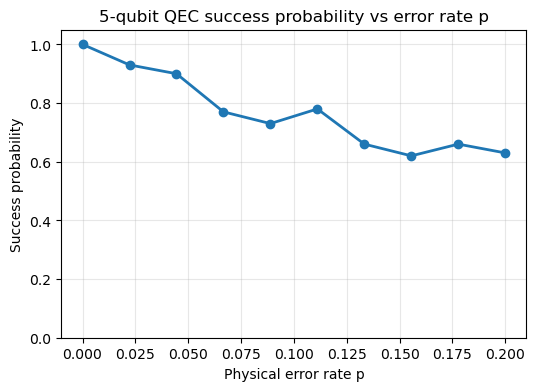

Done.


In [22]:
# choose which logical state to encode via two classical bits
x_bits = (0,0)  # this means we encode |0_L> in our convention

# choose range of physical error rates to test
p_values = np.linspace(0.0, 0.2, 10)  

results = plot_results(
    x_bits,
    p_values,
    100,   # Monte Carlo trials per p
    1           # 1 shot per circuit
)

print("Done.")
